# Forbes' 2025 Global 2000

In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

#### 1. Web Scraping

Site: https://www.forbes.com/lists/global2000/      
We will be scraping the table records listing the top 2000 public companies in the world.

In [ ]:
base_url = "https://www.forbes.com/lists/global2000/"
records = []

# Collect HTML data from this page
response = requests.get(base_url)

# Parse content
content = response.content
parsed_content = BeautifulSoup(content, 'html.parser')

# Each row is wrapped in <a class="table-row ...">
for row in parsed_content.find_all("a", class_="table-row"):
    cols = row.find_all("div", class_="row-cell-value")
    if len(cols) >= 8:  # ensure we have all columns
        records.append([col.get_text(strip=True) for col in cols])


In [ ]:
# Converting the collected records to a dataframe
column_headers = ["RANK", "NAME", "HEADQUARTERS", "INDUSTRY", "SALES", "PROFIT", "ASSETS", "MARKET VALUE"]
df = pd.DataFrame(records, columns=column_headers)

In [3]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE
0,1,JPMorganChase,United States,Banking,$285.11 B,$59.36 B,"$4,357.86 B",$677.8 B
1,2,Berkshire Hathaway,United States,Insurance,$371.43 B,$89 B,"$1,153.88 B","$1,145.46 B"
2,3,ICBC,China,Banking,$221.96 B,$50.84 B,"$6,688.6 B",$251.33 B
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,$480.15 B,$104.97 B,$645.03 B,"$1,663.38 B"
4,5,Amazon,United States,Retail and Wholesale,$637.96 B,$59.25 B,$624.89 B,"$2,005.64 B"


In [39]:
df.isna().sum()

RANK            0
NAME            0
HEADQUARTERS    0
INDUSTRY        0
SALES           0
PROFIT          0
ASSETS          0
MARKET VALUE    0
dtype: int64

In [13]:
# Let's first save this scraped dataset before proceeding to the Data Cleaning stage.
df.to_csv("Original_Scraped_data.csv", index=False)

### 2. Data Cleaning

In [31]:
# The first thing that catches my eye are the numeric values. 
# Let's just retain the numbers since we know all of them are in Billions (B) and the currency is Dollars ($)

df = pd.read_csv("Original_Scraped_data.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   RANK          2000 non-null   object
 1   NAME          2000 non-null   object
 2   HEADQUARTERS  2000 non-null   object
 3   INDUSTRY      2000 non-null   object
 4   SALES         2000 non-null   object
 5   PROFIT        2000 non-null   object
 6   ASSETS        2000 non-null   object
 7   MARKET VALUE  2000 non-null   object
dtypes: object(8)
memory usage: 125.1+ KB


In [ ]:
# # We'll will be using Regex for pattern matching and use .replace along with it
def numeric_col_cleaning(col_name):
    # Remove $ and B/M/K
    df.loc[:, col_name] = df[col_name].str.replace(r'[$B]', '', regex=True) 

    # Strip any whitespaces
    df[col_name] = df[col_name].str.strip()


    
numeric_col_cleaning('SALES')
numeric_col_cleaning('PROFIT')
numeric_col_cleaning('ASSETS')
numeric_col_cleaning('MARKET VALUE')

In [ ]:
# We'll will be using Regex for pattern matching replace all the $ signs, B (billion)/M (million)/K (thousands) signs
# with empty strings and remove any whitespaces if present.
# We will be keeping all the values in billions

import re

def numeric_col_cleaning(value: str) -> float:
    match value.upper():
        case value if 'K' in value:
            return float((re.sub(r'[\$,K]', '', value)).strip()) / 1000000
        case value if 'M' in value:
            return float((re.sub(r'[\$,M]', '', value)).strip()) / 1000
        case value if 'B' in value:
            return float((re.sub(r'[\$,B]', '', value)).strip())
        case _:
            return float((re.sub(r'[\$,]', '', value)).strip())

In [ ]:
df.loc[:, 'SALES'] = df['SALES'].apply(numeric_col_cleaning)
df.loc[:, 'PROFIT'] = df['PROFIT'].apply(numeric_col_cleaning)
df.loc[:, 'ASSETS'] = df['ASSETS'].apply(numeric_col_cleaning)
df.loc[:, 'MARKET VALUE'] = df['MARKET VALUE'].apply(numeric_col_cleaning)

In [ ]:
# Convert all the columns to Numeric type (float64)
df[['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE']] = df[['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE']].apply(pd.to_numeric)

In [45]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.8
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.0,1153.88,1145.46
2,3,ICBC,China,Banking,221.96,50.84,6688.6,251.33
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.15,104.97,645.03,1663.38
4,5,Amazon,United States,Retail and Wholesale,637.96,59.25,624.89,2005.64


In [ ]:
# Checking if any other columns need to be cleaned or formatted
df

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE
0,1,JPMorganChase,United States,Banking,285.110,59.3600,4357.86,677.800
1,2,Berkshire Hathaway,United States,Insurance,371.430,89.0000,1153.88,1145.460
2,3,ICBC,China,Banking,221.960,50.8400,6688.60,251.330
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.150,104.9700,645.03,1663.380
4,5,Amazon,United States,Retail and Wholesale,637.960,59.2500,624.89,2005.640
...,...,...,...,...,...,...,...,...
1995,"1,996",Dino Polska,Poland,Food Markets,7.360,0.3781,3.16,13.840
1996,"1,997",China Aviation Oil,Singapore,Trading Companies,15.520,0.0784,1.99,0.559
1997,"1,998",Jet2,United Kingdom,Business Services & Supplies,8.790,0.6288,7.95,3.930
1998,"1,998",Keiyo Bank,Japan,Banking,0.474,0.0927,42.56,0.679


In [68]:
df.to_csv("Cleaned_data.csv", index=False)

### 3. Creating columns for analysis

In [ ]:
# Let's take a look at the Headquarters column first
df = pd.read_csv("Cleaned_data.csv")
df=df[df["SALES"] > 0]

In [5]:
# Here each country is classified as a developed, emerging or frontier market
market_classification = {
    # Developed Markets
    "Australia": "Developed",
    "Austria": "Developed",
    "Belgium": "Developed",
    "Bermuda": "Developed",
    "Canada": "Developed",
    "Cayman Islands": "Developed",
    "Denmark": "Developed",
    "Finland": "Developed",
    "France": "Developed",
    "Germany": "Developed",
    "Hong Kong": "Developed",
    "Ireland": "Developed",
    "Israel": "Developed",
    "Italy": "Developed",
    "Japan": "Developed",
    "Luxembourg": "Developed",
    "Netherlands": "Developed",
    "Norway": "Developed",
    "Portugal": "Developed",   
    "Singapore": "Developed",
    "Spain": "Developed",
    "Sweden": "Developed",
    "Switzerland": "Developed",
    "United Kingdom": "Developed",
    "United States": "Developed",

    # Emerging Markets
    "Argentina": "Emerging",
    "Brazil": "Emerging",
    "Chile": "Emerging",
    "China": "Emerging",
    "Colombia": "Emerging",
    "Czech Republic": "Emerging",
    "Egypt": "Emerging",
    "Greece": "Emerging",
    "Hungary": "Emerging",
    "India": "Emerging",
    "Indonesia": "Emerging",
    "Kuwait": "Emerging",
    "Malaysia": "Emerging",
    "Mexico": "Emerging",
    "Peru": "Emerging",
    "Philippines": "Emerging",
    "Poland": "Emerging",
    "Qatar": "Emerging",
    "Saudi Arabia": "Emerging",
    "South Africa": "Emerging",
    "South Korea": "Emerging",
    "Taiwan": "Emerging",
    "Thailand": "Emerging",
    "Turkey": "Emerging",
    "United Arab Emirates": "Emerging",

    # Frontier Markets
    "Bahrain": "Frontier",
    "Cyprus": "Frontier",
    "Jordan": "Frontier",
    "Kazakhstan": "Frontier",
    "Lebanon": "Frontier",
    "Morocco": "Frontier",
    "Oman": "Frontier",
    "Panama": "Frontier",
    "Romania": "Frontier",
    "Slovenia": "Frontier",
    "Vietnam": "Frontier"
}


In [6]:
# Now lets create a new column that classifies a country as a Developed/Emerging/Frontier market
df['MARKET TYPE'] = df['HEADQUARTERS'].map(market_classification)

In [7]:
df.head(2)

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80,Developed
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46,Developed


### Answering Business Questions

#### 1. Industry & Market Trends

##### Question 1: Which industries dominate the Global 2000 in terms of market value or sales?

In [ ]:
grouped_industry = (df.groupby('INDUSTRY').agg({'MARKET VALUE': 'sum', 'SALES' : 'sum'})).sort_values(by = ['SALES'], ascending=[False])

In [ ]:
grouped_industry.head(5) # Ordered by market value

# Insights:
# IT Software & Services dominates in terms of Market Value with $13300 B
# Banking comes 2nd in line with ~ $9900 B

,MARKET VALUE,SALES
INDUSTRY,,
IT Software & Services,13314.06,2001.633
Banking,9922.81,6432.954
Semiconductors,6020.81,733.952
Oil & Gas Operations,5317.09,5231.750
Technology Hardware & Equipment,5268.89,1996.864


In [ ]:
grouped_industry.head(5) # Ordered by market value

# Insights
# Banking dominates in terms of Sales with $6400 B 
# Oil & Gas Operations comes second with $5200 B and also manages to come within the top 5 industries that dominate in terms
# of Market Value (in 4th place)

,MARKET VALUE,SALES
INDUSTRY,,
Banking,9922.810,6432.954
Oil & Gas Operations,5317.090,5231.750
Insurance,4869.964,4376.690
Consumer Durables,2983.678,3789.550
Retailing,3908.163,3592.410


##### Question 2: Do some industries achieve higher profitability margins (profit/sales) than others?

In [ ]:
# Profit Margin = % of Revenue that becomes Profit
# Formula: Profit Margin = Profit / Sales

# Let's create a new column 'Profit Margin'
df['PROFIT MARGIN'] = df['PROFIT'] / df['SALES']

In [30]:
# We will now group by the industry and compute the median profit margins for each industry
industry_margins = df.groupby('INDUSTRY').agg({"PROFIT MARGIN": 'mean'}).sort_values(by='PROFIT MARGIN', ascending=False)

In [ ]:
industry_margins.head()
# Insights : Top 2 => Diversified Financials and Construction, Chemicals, Raw Materials industry
# Probably because of increase in preference for "Rear Earth Minerals"

,PROFIT MARGIN
INDUSTRY,
Diversified Financials,0.431460
"Construction, Chemicals, Raw Materials",0.319767
Utilities,0.225972
Drugs & Biotechnology,0.194733
Banking,0.184947


In [ ]:
industry_margins.tail()
# At the bottom table lie the Automotive and Media industry
# A probable reason: ...

,PROFIT MARGIN
INDUSTRY,
Chemicals,0.058002
Trading Companies,0.036073
Food Markets,0.029606
Automotive (Automotive and Suppliers),0.021742
Media,0.016858


##### Question 3: Which industries are asset-heavy vs. asset-light?

In [ ]:
# In simple words, the amount of assets required by industries to generate revenue
# Formula: Asset Intensity = Assets / Sales

# Creating a new column
df['ASSET INTENSITY'] = df['ASSETS'] / df['SALES']

In [37]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80,Developed,0.208200,15.284837
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46,Developed,0.239614,3.106588
2,3,ICBC,China,Banking,221.96,50.84,6688.60,251.33,Emerging,0.229050,30.134258
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.15,104.97,645.03,1663.38,Emerging,0.218619,1.343393
4,5,Amazon,United States,Retail and Wholesale,637.96,59.25,624.89,2005.64,Developed,0.092874,0.979513


In [38]:
industry_assets = df.groupby("INDUSTRY").agg({"ASSET INTENSITY": 'mean'}).sort_values(by='ASSET INTENSITY', ascending=False)

In [ ]:
industry_assets.head()
# Insights: Diversified Financials and Banking  -> heavy asset

,ASSET INTENSITY
INDUSTRY,
Diversified Financials,23.806902
Banking,22.802628
Insurance,7.807973
Utilities,5.190389
Business Services & Supplies,5.129528


In [ ]:
industry_assets.tail() # Food Markets, Automotive -> Light Asset

,ASSET INTENSITY
INDUSTRY,
Retailing,1.027497
Retail and Wholesale,0.979513
Trading Companies,0.879135
Food Markets,0.638704
Automotive (Automotive and Suppliers),0.602146


#### 2. Geographic / Regional Insights

##### Question 1: How do companies from developed vs. emerging markets compare in market value?

In [54]:
# Group by market type, filter out frontier type
grouped_marker_df = df[df['MARKET TYPE'].isin(['Emerging', 'Developed'])].groupby('MARKET TYPE').agg({"MARKET VALUE": "mean"})

In [ ]:
grouped_marker_df
# Insight: A difference of 71.3% between the market values of Emerging and Developed markets.

,MARKET VALUE
MARKET TYPE,
Developed,55.414683
Emerging,26.263563


##### Question 2: Are there regional differences in average profit margin or return on assets (ROA)?

In [48]:
# Return on assets = Profit / Assets
df['ROA'] = df['PROFIT'] / df['ASSETS']

In [58]:
country_region_map = {
    # MENA
    "Bahrain": "MENA",
    "Egypt": "MENA",
    "Israel": "MENA",
    "Jordan": "MENA",
    "Kuwait": "MENA",
    "Lebanon": "MENA",
    "Morocco": "MENA",
    "Oman": "MENA",
    "Qatar": "MENA",
    "Saudi Arabia": "MENA",
    "United Arab Emirates": "MENA",

    # Europe
    "Austria": "Europe",
    "Belgium": "Europe",
    "Cyprus": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Luxembourg": "Europe",
    "Netherlands": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Romania": "Europe",
    "Slovenia": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Turkey": "Europe",
    "United Kingdom": "Europe",

    # North America
    "Bermuda": "North America",
    "Canada": "North America",
    "Cayman Islands": "North America",
    "United States": "North America",

    # South America
    "Argentina": "South America",
    "Brazil": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Mexico": "South America",
    "Panama": "South America",
    "Peru": "South America",

    # Asia-Pacific
    "Australia": "Asia-Pacific",
    "China": "Asia-Pacific",
    "Hong Kong": "Asia-Pacific",
    "India": "Asia-Pacific",
    "Indonesia": "Asia-Pacific",  
    "Japan": "Asia-Pacific",
    "Kazakhstan": "Asia-Pacific",
    "Malaysia": "Asia-Pacific",
    "Philippines": "Asia-Pacific",
    "Singapore": "Asia-Pacific",
    "South Korea": "Asia-Pacific",
    "Taiwan": "Asia-Pacific",
    "Thailand": "Asia-Pacific",
    "Vietnam": "Asia-Pacific",

    "South Africa": "Africa",
}

In [61]:
df['REGION'] = df['HEADQUARTERS'].map(country_region_map)

In [ ]:
grouped_region = df.groupby('REGION').agg({"ROA":'mean', "PROFIT MARGIN": 'mean'}).sort_values(by=["ROA", "PROFIT MARGIN"], ascending=[False, False])
grouped_region

# Insights = ...

,ROA,PROFIT MARGIN
REGION,,
South America,0.062555,0.248654
North America,0.061110,0.120785
MENA,0.047905,0.239552
Europe,0.047891,0.173004
Asia-Pacific,0.042924,0.138779
Africa,0.021381,0.116451


#### 3. Financial Performance Analysis

##### Question 1: Is there a strong correlation between assets and market value? (Do investors reward large asset bases?)

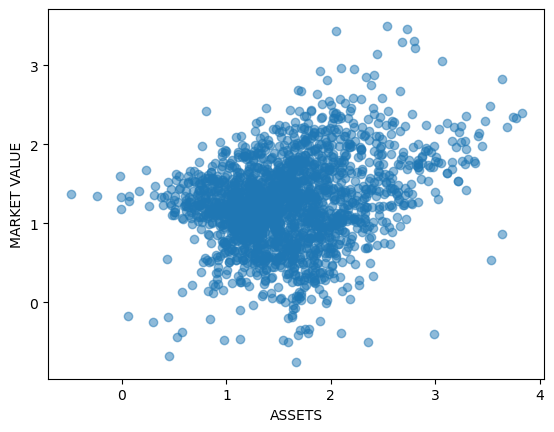

In [69]:
# Scatter plot between assets and market value column
import matplotlib.pyplot as plt
plt.scatter(np.log10(df['ASSETS']), np.log10(df['MARKET VALUE']), alpha=0.5)
plt.xlabel('ASSETS')
plt.ylabel('MARKET VALUE')
plt.show()

In [70]:
pearsons_corr = df["ASSETS"].corr(df["MARKET VALUE"], method="pearson")
pearsons_corr

0.15817813534744882

In [71]:
spearman_corr = df["ASSETS"].corr(df["MARKET VALUE"], method="spearman")
spearman_corr

0.21378342306415185

In [ ]:
# This tells us that: There is a low or moderate correlation between asset and market value 
# So, asset size doesn’t necessarily translate into market value

##### Question 2: Which companies/industries generate the highest return on equity or assets?

##### Question 3: Are there firms with high market value but relatively low sales or profit → overvalued growth companies?


#### 4. Rank & Valuation Dynamics

##### Question 1: What financial metrics best explain a company’s rank (e.g., is rank driven more by sales, profit, or market value)?


##### Question 2: Are top-ranked companies concentrated in a few industries or countries?


##### Question 3: Do the top 10% ranked companies show fundamentally different metrics compared to the rest?

##### Question 4: Which companies look undervalued (high profit/assets but relatively low market value)?